<a href="https://colab.research.google.com/github/CeliaDiazSanchez/Data-Mining/blob/LAB02/LAB02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LABORATORIO 2**
**Grupo**: B01

**Integrantes**: Claudia Esnarrizaga, Ana Robledano, Celia Díaz, Julia Callaba

## **PRÁCTICA 1 (Reglas de Asociación)**

##**Enunciado**

Usa la librería `mlxtend` que nos permita solucionar todos los problemas relacionados con las reglas de
asociación. Para ello tendremos que usar el algoritmo Apriori y una serie de métodos para obtener la distinta
información que este genera.

Usaremos la librería con el Dataset **Market_Basket_Optimisation.csv** que se ha proporcionado.

Prueba al menos tres configuraciones de soporte y frecuencia para cada tipo de puntuación.

Importamos las librerías necesarias y el archivo.

In [82]:
import requests
import warnings
import pandas as pd
import numpy as np
import plotly.express as px
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import matplotlib.pyplot as plt

# URL del archivo CSV en GitHub
url = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB02/Market_Basket_Optimisation.csv"
nombre = 'Market_Basket_Optimisation.csv'


# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")

Archivo descargado exitosamente.


Cargamos el archivo de Market_Basket_Optimisation CSV en un DataFrame de pandas que llamamos ds.

In [83]:
ds = pd.read_csv('Market_Basket_Optimisation.csv')
# Mostramos las 5 primeras entradas del dataset
ds.head(5)

,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
0,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,low fat yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Exploración y limpieza de la base de datos

Si vemos la base de datos, parece corrupta porque tiene muchos NaNs y sale que el título de cada columna es un alimento. Pero al abrir la base de datos en su formato original, observamos que en realidad son filas con la lista de la compra de 7501 personas.

Por ello, no tenemos que limpiar nada, ya que esos NaNs no nos están sesgando, simplemente delimitan la información.

Estas serían las 10 entradas líneas de nuestra base de datos:
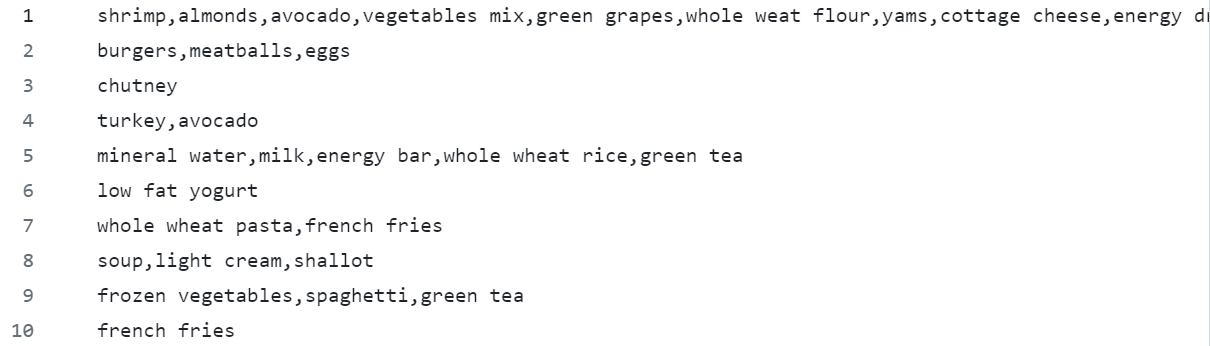

Se trata de una base de datos con listas de compras de productos de supermercado.

In [84]:
ds.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(7500, 20)

Tiene `7501` **filas** (más 1 de la fila de etiquetas de columna que conforma una compra más). Y `20` **columnas** pero que no aportan ninguna información ya que los elementos son productos ordenados.

Queremos registrar todos los productos en una lista para estudiarlos posteriormente.

In [85]:
# Inicializamos la lista de nombres de productos
transacciones = []
# Guardamos en una lista los elementos Del dataFrame
# Las etiquetas de columna (que representan la primera transacción) + Resto de productos en el DataFrame
transacciones = ds.columns.tolist()  + ds.stack().tolist()

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



El método `stack()` en pandas se utiliza para "apilar" los niveles de columna en un DataFrame, lo que significa que convierte las columnas en el nivel más interno del índice. Antes hemos transpuesto el DataFrame para que lo recorra por filas y no por columnas, así se mantiene el orden de las transacciones, aunque para el caso de contar las frecuencias con `k=1` el orden no importará.

En resumen, `ds.T.stack().tolist()` toma un DataFrame, lo transpone para que las filas se conviertan en columnas y viceversa, apila todas las columnas convertidas en filas, elimina cualquier fila que contenga un valor NaN y finalmente convierte los valores en una lista de Python.







Como son muchos datos (7501 filas con varios elementos cada una), sale un warning de la librería numpy que vamos a ignorar.

In [86]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

Mostramos las primeras 25 compras.

In [87]:
transacciones[:20]

['shrimp',
 'almonds',
 'avocado',
 'vegetables mix',
 'green grapes',
 'whole weat flour',
 'yams',
 'cottage cheese',
 'energy drink',
 'tomato juice',
 'low fat yogurt',
 'green tea',
 'honey',
 'salad',
 'mineral water',
 'salmon',
 'antioxydant juice',
 'frozen smoothie',
 'spinach',
 'olive oil']

Comprobamos que la lista obtenida coincide con los valores del DataFrame ignorando los NaNs.

In [88]:
ds.head(3)

,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
0,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Contamos con `29363` productos comprados. Recordamos que pueden repetirse entre las transacciones.

In [89]:
len(transacciones)

29363

Y `120` productos únicos.

In [90]:
len(set(transacciones))

120

Para evitar errores de transcripción, como el mismo producto escrito en mayúsculas, pasamos todos los elementos de la lista a minúsculas.

In [91]:
# Convertir todos los elementos a minúsculas
transacciones = [elemento.lower() for elemento in transacciones]

## **Resolución**

Instalamos la librería `mlxtend`. Esta librería se utiliza comúnmente para extender las capacidades de otras bibliotecas populares de machine learning, como scikit-learn.

In [92]:
!pip install mlxtend

Anteriormente hemos filtrado los datos y los hemos introducimos en una lista para aplicar el algoritmo Apriori.

Es necesario tener las transacciones en un array unidimensional porque el algoritmo Apriori de `mlxtend` espera un conjunto de transacciones, donde cada transacción es una lista de elementos.

###**Preprocesamiento y análisis exploratorio de datos**

#### **k = 1**

**1. Creación del DataFrame inicial:**

Contiene todos los productos tantas veces como hayan sido comprados.

In [93]:
df = pd.DataFrame(transacciones, columns=["items"])

**2. Eliminar filas con valor "nan" en la columna 'items'**

En este caso, como ya hemos filtrado los datos anteriormente, no hay ningún NaN que eliminar.

In [94]:
cantidad_nans = df.isna().sum().sum()
if cantidad_nans != 0:
  indexNames = df[df['items'] == "nan" ].index
  df.drop(indexNames , inplace=True)
  print('Se eliminaron los NaNs')
else:
  print('No hay NaNs en el data frame')

No hay NaNs en el data frame


**3. Agrupar y contar la frecuencia de cada elemento ('items'):**

Con `value_counts()` se cuenta la frecuencia de cada valor único en el DataFrame original.

In [95]:
df.value_counts()

items        
mineral water    1788
eggs             1348
spaghetti        1306
french fries     1282
chocolate        1230
                 ... 
bramble            14
cream               7
napkins             5
water spray         3
 asparagus          1
Length: 120, dtype: int64

Usaremos esta función y reorganizaremos los resultados en un nuevo DataFrame (df_table) con dos columnas: una columna que contiene los valores únicos y otra columna que contiene la frecuencia de cada valor único.

In [96]:
df_table = df.value_counts().reset_index().rename(columns={ 0: "Frecuencia soporte"})
# .reset_index(): resetea el índice de la Serie resultante de value_counts() para convertir los índices en una nueva columna del DataFrame
# .rename(): la columna de frecuencia se renombra como "Frecuencia soporte" para mayor claridad

Obtenemos un DataFrame con 2 columnas, para el nombre del producto y su frecuencia y 120 entradas para cada producto (único).

In [97]:
df_table.shape

(120, 2)

**4. Visualización de las primeras 10 frecuencias con estilo de degradado de color:**

In [98]:
df_table.head(10).style.background_gradient(cmap='Blues')

,items,Frecuencia soporte
0,mineral water,1788
1,eggs,1348
2,spaghetti,1306
3,french fries,1282
4,chocolate,1230
5,green tea,991
6,milk,972
7,ground beef,737
8,frozen vegetables,715
9,pancakes,713


Cada línea muestra un elemento y la cantidad de veces que aparece en las transacciones. Está ordenado de mayor a menor, siendo **"mineral water"** el elemento que más aparece en las transacciones y *asparagus* el que menos (solamente aparece una vez).

A continuación lo mostraremos usando un `treemap interactivo` para visualizar la frecuencia de los 60 elementos con la mayor frecuencia en el conjunto de datos.

In [191]:
# Desactivamos los warnings
warnings.filterwarnings('ignore')

df_table["all"] = "60 items that have highest freqs"

fig = px.treemap(df_table.head(60), path=['all', "items"], values='Frecuencia soporte',
                  color=df_table["Frecuencia soporte"].head(60), hover_data=['items'],
                  color_continuous_scale='Blues',
                )

fig.show()

# Volvemos a activar los warnings
warnings.filterwarnings('default')
# Eliminamos la columna auxiliar que usamos para el treemap.
df_table.drop(columns='all',inplace=True)

Observamos que los productos más frecuentes después del agua son los huevos, spaghetti, patatas fritas y el chocolate.  Sin embargo el producto "pasta" que podría englobar los spaguettis tiene una frecuencia más baja. Y esto puede causar imprecisiones.

In [100]:
df_table[(df_table['items'] == 'pasta') | (df_table['items'] == 'spaghetti')]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,items,Frecuencia soporte
2,spaghetti,1306
59,pasta,118


Como los spaguetti es un tipo de pasta, consideramos que sería más interesante agrupar esos 2 items como uno solo. Ya que el supermercado debería colocar todos los productos de pasta en el mismo sitio.

Por ejemplo, si obtuviésemos una regla del tipo `spaghetti -> pancakes`, querríamos colocar los spaghettis cerca de los pancakes, y los otros tipos de pasta también deberían estar en el mismo sitio que los spaghetti para mayor comodidad y eficiencia logística.

Se podría tener en cuenta los spaghetti por separado si se quisiese abastecer el supermercado, sabiendo que se necesitaría mayor cantidad de spaghetti que de los otros tipos de pasta.

In [101]:
# Cambiamos los valores de spaghetti por pasta en todo lo anterior
ds.replace('spaghetti','pasta', inplace=True)
df.replace('spaghetti','pasta', inplace=True)
df_table = df.value_counts().reset_index().rename(columns={ 0: "Frecuencia soporte"})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



Ahora la tabla de productos con sus frecuencias tiene una fila menos.

In [102]:
df_table.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(119, 2)

Con este cambio el nuevo mapa de frecuencias sería:

In [103]:
# Desactivamos los warnings
warnings.filterwarnings('ignore')

df_table["all"] = "60 items that have highest freqs"

fig = px.treemap(df_table.head(60), path=['all', "items"], values='Frecuencia soporte',
                  color=df_table["Frecuencia soporte"].head(60), hover_data=['items'],
                  color_continuous_scale='Blues',
                )

fig.show()

# Volvemos a activar los warnings
warnings.filterwarnings('default')
# Eliminamos la columna auxiliar que usamos para el treemap.
df_table.drop(columns='all',inplace=True)

El producto **pasta** ha mejorado su posición en el ranking de frecuencias, ya que al agrupar los spaghetti con pasta, se sumaron las frecuencias soportes de ambos.

#### **k = 2**

Realizamos el mismo proceso para k = 2. Ahora nuestra lista de transacciones será una lista de listas, con las combinaciones de los elementos anteriores.

In [104]:
# Desactivamos los warnings
warnings.filterwarnings('ignore')

# Guardar los valores de ds en una matriz
# Recordamos que los nombres de las columnas son la primera fila de la matriz
k2_transacciones =  np.vstack((ds.columns, ds.values.astype(str)))

# Volvemos a activar los warnings
warnings.filterwarnings('default')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [105]:
k2_transacciones[:2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array([['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes',
        'whole weat flour', 'yams', 'cottage cheese', 'energy drink',
        'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad',
        'mineral water', 'salmon', 'antioxydant juice',
        'frozen smoothie', 'spinach', 'olive oil'],
       ['burgers', 'meatballs', 'eggs', 'nan', 'nan', 'nan', 'nan',
        'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan',
        'nan', 'nan', 'nan', 'nan']], dtype=object)

`TransactionEncoder` es una herramienta de la librería `mlxtend` diseñada para convertir una lista de transacciones en una matriz binaria.

En esta matriz, cada columna corresponde a un item, y cada fila representa una transacción, con valores binarios indicando la presencia o ausencia de cada item en dicha transacción.

El proceso de ajuste y transformación se realiza mediante la combinación de `te.fit(transacciones).transform(transacciones)`, donde se ajusta el `TransactionEncoder` a las transacciones y se transforman en una matriz binaria.

Posteriormente, crearemos un DataFrame de pandas (`pd.DataFrame`) con la matriz binaria transformada, utilizando las etiquetas originales de los items como nombres de columnas. La visualización de las primeras filas del DataFrame mediante `ds.head()` nos permite inspeccionar la estructura y contenido de la matriz binaria resultante.

In [106]:
TE = TransactionEncoder()

# Ajustar y transformar las transacciones usando TransactionEncoder
matriz = TE.fit(k2_transacciones).transform(k2_transacciones)

# Crear un DataFrame con la matriz transformada y columnas etiquetadas
ds_TE = pd.DataFrame(matriz, columns = TE.columns_)

# Mostrar las primeras filas del DataFrame resultante
ds_TE.head(5)

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


Creamos un nuevo DataFrame que conserva todas las filas, pero solo incluye las columnas cuyos nombres corresponden a los items únicos encontrados en el DataFrame `df_table`.

In [107]:
ds_limpia = df_table["items"].values
ds_TE = ds_TE.loc[:, ds_limpia]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



####**FP-Growth**

Utilizamos el algoritmo FP-Growth (Frequent Pattern Growth) para encontrar conjuntos de ítems frecuentes.

In [108]:
itemsets_frec_005 = fpgrowth(ds_TE, min_support=0.05, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [109]:
itemsets_frec_005.sort_values("support",ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
0,0.238368,(mineral water)
13,0.187975,(pasta)
6,0.179709,(eggs)
11,0.170911,(french fries)
17,0.163845,(chocolate)
1,0.132116,(green tea)
9,0.129583,(milk)
22,0.098254,(ground beef)
14,0.095321,(frozen vegetables)
20,0.095054,(pancakes)


Esto nos revela varios patrones de compra en el conjunto de datos.

Los productos individuales más frecuentes son:
- mineral water
- pasta
- eggs
- french fries

Además, se identificaron combinaciones frecuentes, como:
- (mineral water, pasta)
- (mineral water, chocolate)
- (mineral water, eggs)


Esto nos sugiere tendencias de compra específicas, lo que podría ser valioso para estrategias de colocación de productos y promociones en el supermercado. El análisis proporciona información sobre la frecuencia y asociaciones de productos que podrían ser utilizadas para mejorar la experiencia del cliente y aumentar las ventas.

Concretamente el agua debería ser un producto que se encontrase en el medio del establecimiento, teniendo a su alrededor pasta, chocolate y huevos. Así se aprovecha al máximo estas relaciones de compra.

A continuación probaremos con un soporte mayor:

In [110]:
itemsets_frec_01 = fpgrowth(ds_TE, min_support=0.1, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [111]:
itemsets_frec_01.sort_values("support",ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
0,0.238368,(mineral water)
5,0.187975,(pasta)
2,0.179709,(eggs)
4,0.170911,(french fries)
6,0.163845,(chocolate)
1,0.132116,(green tea)
3,0.129583,(milk)


Al aumentar el soporte mínimo, nos da muchos menos itemsets. Probemos con uno aún menor que el 0.05:

In [112]:
itemsets_frec_0025 = fpgrowth(ds_TE, min_support=0.025, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [113]:
itemsets_frec_0025.sort_values("support",ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
0,0.238368,(mineral water)
22,0.187975,(pasta)
13,0.179709,(eggs)
19,0.170911,(french fries)
27,0.163845,(chocolate)
...,...,...
42,0.025730,(cereals)
12,0.025730,(vegetables mix)
70,0.025597,"(pancakes, pasta)"
49,0.025463,"(green tea, eggs)"


Ahora, como podíamos esperar, tenemos muchos más patrones.

**¿Qué diferencias hay entre usar soporte y frecuencia? Respalda la respuesta con datos**

La principal diferencia radica en cómo se expresan los resultados. El soporte es una medida relativa que representa la proporción de transacciones que contiene un conjunto específico, mientras que la frecuencia es una medida absoluta que cuenta cuántas veces aparece ese conjunto.

Por lo tanto, para el caso en el que el soporte mínimo es 0.01, tendríamos que sacar la frecuencia soporte que equivaldría a la multiplicación de 0.01 * número total de transacciones que tenemos (7501).

Esto significa que estamos buscando conjuntos de ítems que aparezcan al menos 750 veces en las 7501 transacciones.


In [114]:
# Frecuencia mínima requerida
frecuencia_minima = 750

# Calcular el soporte mínimo
min_support = frecuencia_minima / len(ds)

# Utilizar fpgrowth con min_support calculado
itemsets_frec_01 = fpgrowth(ds_TE, min_support=min_support, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [115]:
itemsets_frec_01.sort_values("support",ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
0,0.238368,(mineral water)
5,0.187975,(pasta)
2,0.179709,(eggs)
4,0.170911,(french fries)
6,0.163845,(chocolate)
1,0.132116,(green tea)
3,0.129583,(milk)


Efectivamente nos da lo mismo que haciéndolo con el mínimo soporte.

####**Reglas de asociación**

Ahora crearemos las reglas de asociación para el caso donde el soporte mínimo es 0.05:

In [116]:
reglas_asociacion_005 = association_rules(itemsets_frec_005, metric = "lift", min_threshold = 1.1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [117]:
reglas_asociacion_005.sort_values("confidence", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(pasta),(mineral water),0.187975,0.238368,0.061192,0.325532,1.365668,0.016385,1.129233,0.329741
4,(chocolate),(mineral water),0.163845,0.238368,0.052660,0.321400,1.348332,0.013604,1.122357,0.308965
0,(eggs),(mineral water),0.179709,0.238368,0.050927,0.283383,1.188845,0.008090,1.062815,0.193648
2,(mineral water),(pasta),0.238368,0.187975,0.061192,0.256711,1.365668,0.016385,1.092476,0.351558
5,(mineral water),(chocolate),0.238368,0.163845,0.052660,0.220917,1.348332,0.013604,1.073256,0.339197
1,(mineral water),(eggs),0.238368,0.179709,0.050927,0.213647,1.188845,0.008090,1.043158,0.208562


**¿Qué tipo de reglas desaparecen según la configuración usada y el tipo de puntuación? ¿Por qué?**

Las reglas que han desaparecido son aquellas asociadas con items o combinaciones menos frecuentes y asociaciones más débiles. Si hacemos las reglas de asociación con aquellos itemsets en los que el soporte mínimo es menor, por ejemplo, las de 0.025, entonces obtendremos algunas reglas que se han descartado para el caso de soporte mínimo = 0.05.

Vamos a comprobarlo:

In [118]:
reglas_asociacion_0025 = association_rules(itemsets_frec_0025, metric = "lift", min_threshold = 1.1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [119]:
reglas_asociacion_0025.sort_values("confidence", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
6,(olive oil),(mineral water),0.065858,0.238368,0.027596,0.419028,1.757904,0.011898,1.310962,0.461536
42,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401,0.474369
44,(ground beef),(pasta),0.098254,0.187975,0.040261,0.409769,2.179915,0.021792,1.375776,0.600242
29,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,0.013007,1.218270,0.402413
14,(milk),(mineral water),0.129583,0.238368,0.047994,0.370370,1.553774,0.017105,1.209650,0.409465
38,(pancakes),(mineral water),0.095054,0.238368,0.033729,0.354839,1.488616,0.011071,1.180529,0.362712
4,(shrimp),(pasta),0.071457,0.187975,0.025197,0.352612,1.875846,0.011764,1.254310,0.502838
47,(cake),(mineral water),0.081056,0.238368,0.027463,0.338816,1.421397,0.008142,1.151921,0.322617
12,(burgers),(eggs),0.087188,0.179709,0.028796,0.330275,1.837830,0.013128,1.224818,0.499424
25,(pasta),(mineral water),0.187975,0.238368,0.061192,0.325532,1.365668,0.016385,1.129233,0.329741


Efectivamente, podemos comprobar que disminuyendo el soporte nos saca muchas más reglas.

**Para una de las configuraciones, interpreta algunas de las reglas que te hayan resultado curiosas obtenidas
usando la clase `association_rules` y un par de configuraciones cambiando la variable `metric` y `min_threshold`.**

Debido a que las reglas que nos genera el itemset con un soporte 0.025 es más exacto y nos da mayores confianzas, vamos a utilizar ese para modificar el valor del lift:

In [120]:
itemsets_rules_lift = association_rules(itemsets_frec_0025, metric="lift", min_threshold=1.3)
itemsets_rules_lift.sort_values("confidence", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(olive oil),(mineral water),0.065858,0.238368,0.027596,0.419028,1.757904,0.011898,1.310962,0.461536
28,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401,0.474369
30,(ground beef),(pasta),0.098254,0.187975,0.040261,0.409769,2.179915,0.021792,1.375776,0.600242
19,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,0.013007,1.218270,0.402413
6,(milk),(mineral water),0.129583,0.238368,0.047994,0.370370,1.553774,0.017105,1.209650,0.409465
24,(pancakes),(mineral water),0.095054,0.238368,0.033729,0.354839,1.488616,0.011071,1.180529,0.362712
0,(shrimp),(pasta),0.071457,0.187975,0.025197,0.352612,1.875846,0.011764,1.254310,0.502838
33,(cake),(mineral water),0.081056,0.238368,0.027463,0.338816,1.421397,0.008142,1.151921,0.322617
4,(burgers),(eggs),0.087188,0.179709,0.028796,0.330275,1.837830,0.013128,1.224818,0.499424
15,(pasta),(mineral water),0.187975,0.238368,0.061192,0.325532,1.365668,0.016385,1.129233,0.329741


Hemos aumentado un poco el valorde `min_threshold` para ver qué nos devuelve y nos depura un poco más las reglas.

Por ejemplo, para la Regla 2: olive oil ----> mineral water, interpretamos que la compra de olive oil está asociada con una mayor probabilidad (1.75 veces más) de comprar mineral water. Esto nos puede indicar una tendencia de los clientes a combinar estos dos productos.

**Dadas las mejores configuraciones. ¿Existen reglas o patrones que se repitan? ¿Podemos generalizar de alguna
manera como se comportan los clientes del supermercado?**

Hemos visto que la mejor configuración es la utilizada anteriormente (soporte = 0.025). No se repite ninguna regla pero sí que es verdad que mineral water está casi siempre incluida, como antecedente y como consecuente.

**Dado un antecesor, devolver todas las reglas que contengan a dicho antecesor.**

In [121]:
antecedente = {"pasta"}

reglas = itemsets_rules_lift[itemsets_rules_lift['antecedents'].apply(lambda x: antecedente.issubset(set(x)))]

print("Reglas que contienen el antecesor deseado:")
reglas.sort_values("confidence", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Reglas que contienen el antecesor deseado:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
15,(pasta),(mineral water),0.187975,0.238368,0.061192,0.325532,1.365668,0.016385,1.129233,0.329741
21,(pasta),(chocolate),0.187975,0.163845,0.040795,0.217021,1.324554,0.009996,1.067916,0.301750
31,(pasta),(ground beef),0.187975,0.098254,0.040261,0.214184,2.179915,0.021792,1.147529,0.666564
9,(pasta),(milk),0.187975,0.129583,0.036928,0.196454,1.516050,0.012570,1.083220,0.419188
17,(pasta),(frozen vegetables),0.187975,0.095321,0.028263,0.150355,1.577357,0.010345,1.064773,0.450759
27,(pasta),(pancakes),0.187975,0.095054,0.025597,0.136170,1.432556,0.007729,1.047598,0.371845
1,(pasta),(shrimp),0.187975,0.071457,0.025197,0.134043,1.875846,0.011764,1.072273,0.574991


Observamos que algunas reglas como:
- (pasta) -> (ground beef)
- (pasta)->	(frozen vegetables)
- (pasta) ->	(shrimp)
Podrían tener la explicación de que son condimentos de la pasta.

**Dado un umbral mínimo devolver todas las reglas que cumplan con dicha confianza**

In [122]:
umbral_confianza = 0.2

reglas_umbral = reglas[reglas['confidence'] >= umbral_confianza]

print("\nReglas que cumplen con el umbral mínimo de confianza:")
reglas_umbral.sort_values("confidence", ascending = False)


Reglas que cumplen con el umbral mínimo de confianza:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
15,(pasta),(mineral water),0.187975,0.238368,0.061192,0.325532,1.365668,0.016385,1.129233,0.329741
21,(pasta),(chocolate),0.187975,0.163845,0.040795,0.217021,1.324554,0.009996,1.067916,0.301750
31,(pasta),(ground beef),0.187975,0.098254,0.040261,0.214184,2.179915,0.021792,1.147529,0.666564


####**Gráficas**

A continuación representaremos las reglas que nos han quedado anteriormente.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

<ipython-input-123-25d922eb09e0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



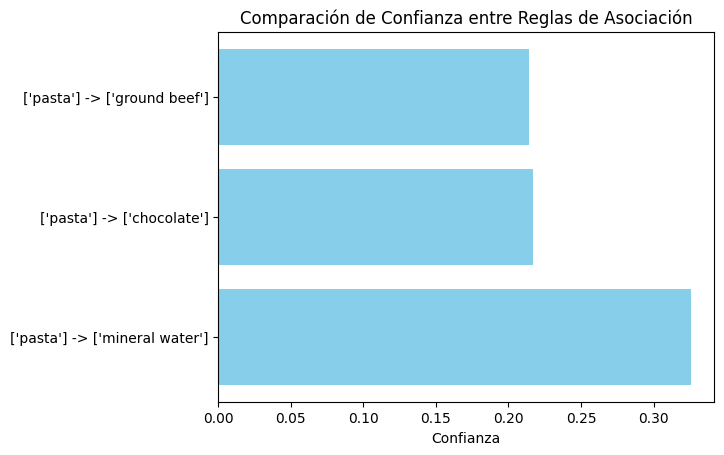

In [123]:
reglas_umbral['etiqueta'] = reglas_umbral.apply(lambda row: f"{list(row['antecedents'])} -> {list(row['consequents'])}", axis=1)

plt.barh(reglas_umbral['etiqueta'], reglas_umbral['confidence'], color='skyblue')
plt.xlabel('Confianza')
plt.title('Comparación de Confianza entre Reglas de Asociación')
plt.show()

Viendo el gráfico, vemos claramente que lo que, con una confianza de 0.35 pasta -> mineral water, es decir, si compras pasta entonces, con una confianza del 35%, comprarás mineral water.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



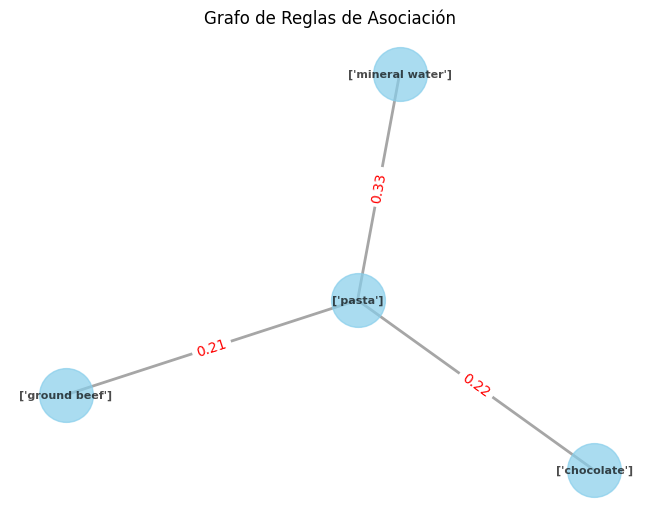

In [124]:
G = nx.Graph()

# Agregar nodos y conexiones al grafo
for idx, row in reglas_umbral.iterrows():
    antecedents_list = list(row['antecedents'])
    consequents_list = list(row['consequents'])

    G.add_node(str(antecedents_list))
    G.add_node(str(consequents_list))
    G.add_edge(str(antecedents_list), str(consequents_list), weight=round(row['confidence'], 2))

# Dibujar el grafo
pos = nx.spring_layout(G)  # Puedes ajustar el layout según tus preferencias
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1500, font_color='black', node_color='skyblue', edge_color='gray', width=2, alpha=0.7, font_weight='bold', edge_cmap=plt.cm.Blues)
labels = nx.get_edge_attributes(G, 'weight')
labels_formatted = {edge: f"{weight:.2f}" for edge, weight in labels.items()}  # Formatear el peso
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels_formatted, font_color='red')

plt.title('Grafo de Reglas de Asociación')
plt.show()

Proponer una oferta de pasta para los que compren carne podría incrementar las ventas del supermercado, además la pasta es una buena combinación con la carne, para hacer platos como pasta a la bolognesa.

Hemos querido representar también las tres reglas definitivas que más confianza tienen:

In [125]:
umbral_confianza = 0.38

reglas_umbral = itemsets_rules_lift[itemsets_rules_lift['confidence'] >= umbral_confianza]

print("\nReglas que cumplen con el umbral mínimo de confianza:")
reglas_umbral.sort_values("confidence", ascending = False)


Reglas que cumplen con el umbral mínimo de confianza:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(olive oil),(mineral water),0.065858,0.238368,0.027596,0.419028,1.757904,0.011898,1.310962,0.461536
28,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401,0.474369
30,(ground beef),(pasta),0.098254,0.187975,0.040261,0.409769,2.179915,0.021792,1.375776,0.600242


Interpretamos que el agua y el aceite son productos de primera necesidad para la mayoría de personas. Esto queda reflejado en la regla (olive oil)-> (mineral water)

Ambos son productos líquidos envasados en botellas, aprovechando esta regla, sería más sencillo transportarlos a la misma zona del supermercado utilizando los mismos vehículos / carros. Además teniendo en cuenta que son productos algo pesados, se podrían colocar cercanos a la salida para que el cliente no tuviese que cargar con tanto peso en su recorrido de compra.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



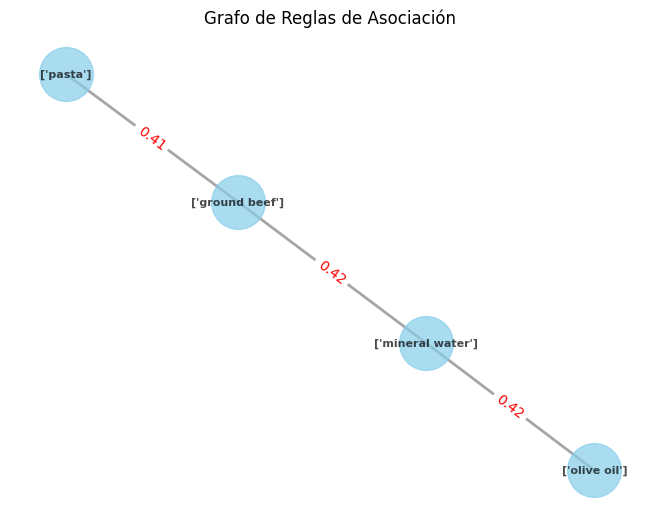

In [126]:
G = nx.Graph()

# Agregar nodos y conexiones al grafo
for idx, row in reglas_umbral.iterrows():
    antecedents_list = list(row['antecedents'])
    consequents_list = list(row['consequents'])

    G.add_node(str(antecedents_list))
    G.add_node(str(consequents_list))
    G.add_edge(str(antecedents_list), str(consequents_list), weight=round(row['confidence'], 2))

# Dibujar el grafo
pos = nx.spring_layout(G)  # Puedes ajustar el layout según tus preferencias
nx.draw(G, pos, with_labels=True, font_size=8, node_size=1500, font_color='black', node_color='skyblue', edge_color='gray', width=2, alpha=0.7, font_weight='bold', edge_cmap=plt.cm.Blues)
labels = nx.get_edge_attributes(G, 'weight')
labels_formatted = {edge: f"{weight:.2f}" for edge, weight in labels.items()}  # Formatear el peso
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels_formatted, font_color='red')

plt.title('Grafo de Reglas de Asociación')
plt.show()

Obtenemos una relación de productos con la que se podría emplear alguna estrategia de ventas. Por ejemplo hacer un anuncio de una persona cocinando con aceite de oliva pasta a la bolognesa, es una combinación que podría incentivar a los clientes a realizar estas compras. A pesar de que el agua no se mencionase en el anuncio, es un producto que ya de por sí individualmente tiene una muy alta frecuencia.

## **PRÁCTICA 2 (Patronces Secuenciales)**




##**Enunciado**

El conjunto de datos “Online Retail.xlsx” contiene productos (definidos por la columna StockCode y
Description) comprados por diferentes clientes (definidos por la columna CustomerID) en diferentes
momentos (definidos por el campo InvoiceDate. Habrá que procesar el fichero para crear una lista de los
distintos clientes con las secuencias de las transacciones de las compras realizadas en distintos instantes (2
puntos).

Una vez hecho esto y analizando esta información se pueden extraer conclusiones sobre en que orden
compran los clientes los productos y así tomar decisiones de negocio. Este estudio se puede llevar a cabo
aplicando el algoritmo Generalized Sequential Patterns utilizando la implementación de éste disponible en la
librería gsppy.

Prueba al menos dos configuraciones de soporte diferentes. (1 punto)
Para una de ellas, interpreta algunos de los patrones secuenciales que te resulten curiosos. (1 punto)

Saca conclusiones de negocio en virtud de algunas de las reglas elegidas por vosotros que mayor confianza
tengan(1 punto)

Librería gsppy:
Podéis encontrar su documentación en el siguiente enlace: https://pypi.org/project/gsppy/

Importamos las librerías necesarias y el archivo.

In [4]:
import requests
import pandas as pd

# URL del archivo CSV en GitHub
url = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB02/Online Retail.xlsx"

nombre = 'Online Retail.xlsx'


# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")

Archivo descargado exitosamente.


Cargamos el archivo de 'Online Retail.xlsx' en un DataFrame de pandas que llamamos `df`.

In [5]:
df = pd.read_excel('Online Retail.xlsx')

df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom


Creamos una copia de `df` para modificarla sin afectar al original

In [6]:
ds = df.copy()
id(df), id(ds)

(132927827071264, 132927073284928)

##**Resolución**

###**Limpieza y preprocesamiento de la base de datos**

Tenemos un DataFrame con 541909 registros y 8 atributos.

In [7]:
df.shape

(541909, 8)

In [8]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom


`df` contiene una base de datos de compras online de varios clientes a lo largo del tiempo. Para cada producto comprado por un cliente en una fecha se lleva un registro de las siguientes variables:

In [9]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

Con los siguientes tipos:

In [10]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

- InvoiceNo: Este es el número de factura que identifica de forma única cada transacción de compra. Cada vez que se realiza una compra, se genera una nueva factura con un número de factura único.

- StockCode: Este es un código único que identifica un producto específico en el inventario de la tienda en línea. Cada producto en el inventario tiene su propio código de stock.

- Description: Esta columna proporciona una descripción del producto asociado con el código de stock. Proporciona información adicional sobre el producto, como su nombre o características.

- Quantity: Esta columna indica la cantidad de unidades del producto que se compraron en la transacción correspondiente. Por ejemplo, si se compra un producto en múltiples cantidades, el valor en esta columna será mayor que 1.

- InvoiceDate: Este es el timestamp que indica la fecha y hora en que se realizó la transacción de compra. Proporciona información sobre cuándo se llevó a cabo la compra.

- UnitPrice: Este es el precio unitario del producto en la moneda local en la que se realizó la transacción. Indica cuánto cuesta una sola unidad del producto.

- CustomerID: Este es el identificador único del cliente que realizó la compra. Cada cliente tiene un CustomerID único asociado con su cuenta en la tienda en línea.

- Country: Esta columna indica el país donde se realizó la transacción. Proporciona información sobre la ubicación geográfica del cliente que realizó la compra.

Los países que compran de la tienda son los siguientes:

In [11]:
import numpy as np
np.sort(df['Country'].unique())

array(['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Hong Kong', 'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon',
       'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'RSA', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'USA', 'United Arab Emirates', 'United Kingdom',
       'Unspecified'], dtype=object)

No parece que haya ningún error de transcripción, aunque sí que hay una categoría llamada `Unspecified`. Como en este estudio de patrones secuenciales no tendremos en cuenta el país, no hará falta hacer ninguna modificación.

###**Algunas cifras del dataset:**

---



Hay transacciones de `4372` clientes distintos determinados por su ID.

In [13]:
df['CustomerID'].unique().size

4372

`4070` productos distintos determinados por su código de producto. No obstante, más adelante analizaremos los códigos para eliminar posibles errores de transcripción o datos irrelevantes.

In [14]:
df['StockCode'].unique().size

4070

`25900` facturas de compra distintas.

In [15]:
df['InvoiceNo'].unique().size

25900

`23260` días en los que hubo transacciones.

In [16]:
df['InvoiceDate'].unique().size

23260

Una factura está compuesta de varios productos por lo que esta se repite en tantos registros como productos contenga.

In [17]:
df['InvoiceNo'].value_counts()

573585     1114
581219      749
581492      731
580729      721
558475      705
           ... 
554023        1
554022        1
554021        1
554020        1
C558901       1
Name: InvoiceNo, Length: 25900, dtype: int64

Los `StockCodes` también se repiten como es de esperar. Productos del mismo tipo pueden ser comprados por personas distintas y/o en días distintos.

In [18]:
df['StockCode'].value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

Sin embargo para un mismo producto asociado a un `StockCode` puede tomar precios por unidad distintos.

In [19]:
df.groupby('StockCode')['UnitPrice'].unique()

StockCode
10002                                   [0.85, 1.66, 1.63, 0.0]
10080                                         [0.85, 0.39, 0.0]
10120                                                    [0.21]
10125                      [0.85, 1.66, 0.42, 0.81, 0.79, 1.63]
10133           [0.85, 1.66, 0.42, 0.81, 0.79, 1.63, 0.83, 0.0]
                                     ...                       
gift_0001_20                                [17.02, 16.67, 0.0]
gift_0001_30                                 [25.53, 25.0, 0.0]
gift_0001_40                                     [34.04, 33.33]
gift_0001_50                                     [42.55, 41.67]
m                                                        [2.55]
Name: UnitPrice, Length: 4070, dtype: object

Y también descripciones distintas, aunque algunas de ellas parecen errores ('nan', 'check')

In [20]:
df.groupby('StockCode')['Description'].unique()

StockCode
10002                          [INFLATABLE POLITICAL GLOBE , nan]
10080                      [GROOVY CACTUS INFLATABLE, nan, check]
10120                                              [DOGGY RUBBER]
10125                                   [MINI FUNKY DESIGN TAPES]
10133                     [COLOURING PENCILS BROWN TUBE, damaged]
                                      ...                        
gift_0001_20    [Dotcomgiftshop Gift Voucher £20.00, to push o...
gift_0001_30            [Dotcomgiftshop Gift Voucher £30.00, nan]
gift_0001_40                 [Dotcomgiftshop Gift Voucher £40.00]
gift_0001_50                 [Dotcomgiftshop Gift Voucher £50.00]
m                                                        [Manual]
Name: Description, Length: 4070, dtype: object

**Nota:** *como aún no se ha limpiado la base de datos, estas cantidades son orientativas. Podría haber errores de transcripción o datos inconsistentes que alteran los resultados. Este análisis a priori es solo para hacernos una idea aproximada de las proporciones de cantidades de clientes, productos, facturas, ... posterior a la limpieza podríamos repetir el proceso para mayor precisión.*

###**Ejemplo**

---



Vamos a tomar la primera factura de ejemplo, para analizar su contenido.

In [21]:
factura_test = df[df['InvoiceNo'] == 573585]
factura_test.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
430237,573585,11001,ASSTD DESIGN RACING CAR PEN,2,2011-10-31 14:41:00,3.29,15287,United Kingdom
430238,573585,15036,ASSORTED COLOURS SILK FAN,15,2011-10-31 14:41:00,1.63,15287,United Kingdom
430239,573585,15039,SANDALWOOD FAN,15,2011-10-31 14:41:00,1.63,15287,United Kingdom
430240,573585,15056BL,EDWARDIAN PARASOL BLACK,1,2011-10-31 14:41:00,12.46,15287,United Kingdom
430241,573585,15056N,EDWARDIAN PARASOL NATURAL,1,2011-10-31 14:41:00,12.46,15287,United Kingdom


In [22]:
factura_test['CustomerID'].unique().size

1

In [23]:
factura_test['InvoiceDate'].unique().size

1

De esta factura podemos sacar 3 observaciones:
- El número de factura no es compartido por más de un cliente.
- El número de factura no es compartido por más de una fecha.
- La factura contiene varios productos determinados por su `StockCode`.
Es decir, para cada compra de cada cliente en una fecha determinada, se crea una factura con ID único y que contiene ID's de productos.

En este caso hay 4 `StockCodes` repetidos, ya que la factura se repite en el dataset 1114 veces y solo hay 1110 `StockCodes` únicos para ese número de factura.

In [24]:
factura_test['StockCode'].unique().size

1110

4 no es una cantidad significativa, podría tratarse de errores en los datos del ejemplo elegido, veamos en otra factura si se da el mismo escenario:

In [25]:
factura_test2 = df[df['InvoiceNo'] == 581219]
# La factura aparece en 749 entradas
print(factura_test2.shape)
# Hay 749 StockCodes distintos asociados al nº de factura, uno para cada entrada
print(factura_test2['StockCode'].unique().size)

(749, 8)
749


En esta ocasión, no se repite ningún `StockCode` en la misma factura.

###**Estudio de NaNs**

Aparecen NaN's en el atributo `Description`, veremos qué porcentaje suponen y qué medidas tomar en base a ello.

In [26]:
df.isna().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [28]:
conteo_nans = df['Description'].isna().sum()
conteo_no_nans = len(df) - conteo_nans

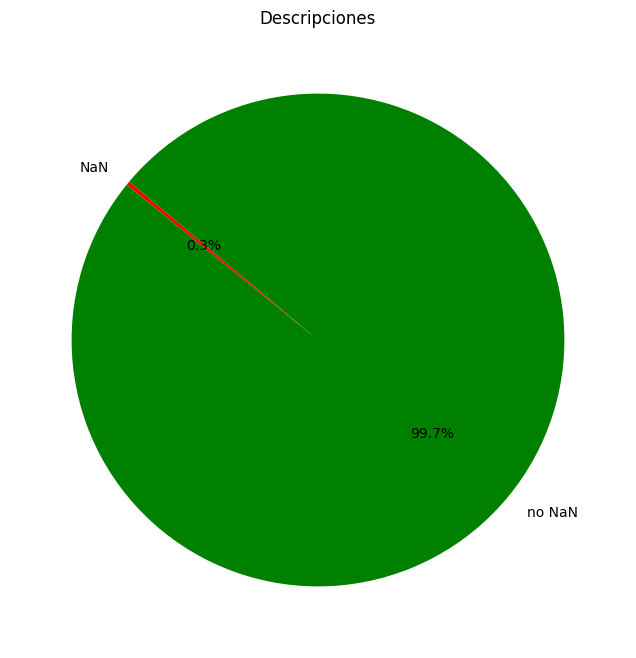

In [29]:
import matplotlib.pyplot as plt

sizes = [conteo_nans, conteo_no_nans]
labels = ['NaN','no NaN']

# Crear un gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',colors=['red','green'], startangle=140)

# Añadir título
plt.title('Descripciones')

# Mostrar el gráfico
plt.show()


Las entradas con descripciones NaN suponen un porcentaje muy bajo de las totales, podríamos eliminar dichas entradas pero antes limpiaremos la base de datos ya que podrían ser eliminados igualmente si pertenecen a registros con otros datos inconsistentes.

###**Limpieza de la base de datos**

####**Cantidades**

Entendemos que la cantidad de un producto es positiva cuando el cliente se lleva de la tienda artículos y negativa cuando los devuelve. Para confirmar esta hipótesis procedemos a analizar los datos con cantidades negativas.

In [30]:
negative = df[df['Quantity'] < 0]
negative.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Observamos que para el `StockCode` 'D', se trata de un descuento, que queda registrado como cantidad negativa.

In [31]:
discounts = df[df['StockCode'] == 'D']
discounts.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498,United Kingdom


In [32]:
print(discounts.shape[0])

77


Queda registrado que hubo `77` descuentos en total, y tomaban las siguientes cantidades negativas en la columna de `Quantity`

In [33]:
print(discounts['Quantity'].unique())

[  -1 -720 -240  -18  -48  -96]


Algunos descuentos toman cifras muy elevadas, esto podría provocar pérdidas a la tienda pero comprobamos que se trata de descuentos con `UnitPrice` muy bajos.

In [34]:
discounts.groupby('Quantity')['UnitPrice'].unique()

Quantity
-720                                               [0.01]
-240                                               [0.03]
-96                                                 [0.7]
-48                                                 [0.2]
-18                                                [1.45]
-1      [27.5, 29.29, 281.0, 267.12, 5.76, 42.5, 26.93...
Name: UnitPrice, dtype: object

Para analizar los demás registros con cantidades negativas, tomamos un ejemplo de un cliente que tiene una cantidad negativa en una de sus compras.

In [35]:
test = df[df['CustomerID'] == 15311]

Queremos ver qué productos están en la transacción de la factura que contiene la cantidad negativa.

In [36]:
test[test['InvoiceNo'] == 'C536383']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom


No compró otros productos en esa transacción.

Veamos si ese cliente compró el set de 3 patos coloreados voladores en otras ocasiones, y si aparecen con cantidades negativas.

In [37]:
test = df[df['CustomerID'] == 15311]
test[test['StockCode'] == '35004C']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


En efecto, realizó varias compras del set, en ocasiones la compra aparece con cantridad del producto negativa, por lo que interpretamos que se trata de devoluciones del producto.

In [38]:
negative.shape[0] - discounts.shape[0]

10547

Parece que las cantidades negativas de productos se refieren a devoluciones o descuentos. Es interesante que de los `541909` eventos de productos comprados, `10421` son devueltos. Podría deberse a varios factores como que el producto estaba defectuoso, talla incorrecta, ... De cualquier manera, se trata de un problema distinto al de patrones secuenciales por lo que vamos a eliminar las entradas con valores negativos.

In [39]:
df = df.drop(df[df['Quantity'] < 0].index)
if df[df['Quantity'] < 0].shape[0] == 0:
  print('Los registros con cantidades de producto negativas fueron eliminados')

Los registros con cantidades de producto negativas fueron eliminados


Por otra parte no hay ninguna cantidad 0 de producto(s) comprados.

In [40]:
df[df['Quantity'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


####**Precios**

Hacemos el mismo proceso con los precios menores o iguales a 0.

In [41]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,15287,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,15287,United Kingdom


Según la descripción se trata de un error de cobro que fue arreglado.

In [42]:
df = df.drop(df[df['UnitPrice'] < 0].index)

A continuación veremos los precios que son 0.

In [43]:
cero_price = df[df['UnitPrice'] == 0]
cero_price.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,15287,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,15287,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,15287,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,15287,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,15287,United Kingdom
1988,536550,85044,NaN,1,2010-12-01 14:34:00,0.0,15287,United Kingdom
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.0,15287,United Kingdom
2025,536553,37461,NaN,3,2010-12-01 14:35:00,0.0,15287,United Kingdom
2026,536554,84670,NaN,23,2010-12-01 14:35:00,0.0,15287,United Kingdom
4348,536765,84952C,NaN,19,2010-12-02 14:43:00,0.0,15287,United Kingdom


A primera vista, aparecen bastantes NaN's. Veamos cuántos hay exactamente para este caso.

In [44]:
cero_price.size

9432

Las descripciones de los eventos con precios igual a cero, son inconsistentes. Podría tratarse de personas que no completaron el proceso de compra, cancelaron el envío u obtuvieron algún artículo gratis como parte de una promoción.

De `9400` registros con precios igual a cero, hay `588` de ellos con NaN en la descripción.

In [45]:
cero_price.isna().sum()

InvoiceNo        0
StockCode        0
Description    592
Quantity         0
InvoiceDate      0
UnitPrice        0
CustomerID       0
Country          0
dtype: int64

`32` clientes que realizaron transacciones con productos con precios igual a cero. Recordamos que anteriormente calculamos que hay `4339` clientes en total, los clientes con transacciones de productos de precio cero, suponen apenas un 0.74% del total y podría tratarse de familiares/amigos de la tienda que obtuvieron productos gratis.

In [46]:
cero_customers = cero_price['CustomerID'].unique().size
print(cero_customers)
normal_customers = df['CustomerID'].unique().size - cero_customers

32


Hacemos el mismo estudio con el número total de registros y el número de registros que contienen precios igual a cero.

In [47]:
cero_registers = cero_price.shape[0]
normal_registers = df.shape[0] - cero_registers

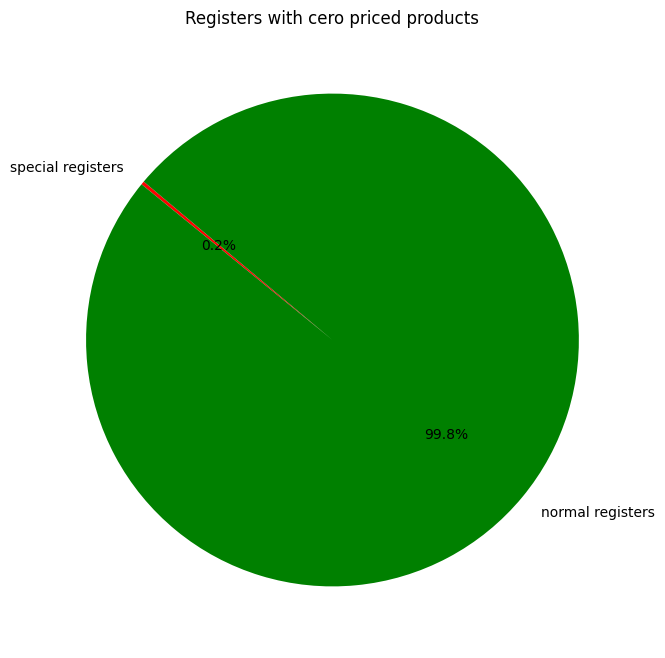

In [48]:
import matplotlib.pyplot as plt

sizes = [cero_registers, normal_registers]
labels = ['special registers','normal registers']

# Crear un gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',colors=['red','green'], startangle=140)

# Añadir título
plt.title('Registers with cero priced products')

# Mostrar el gráfico
plt.show()

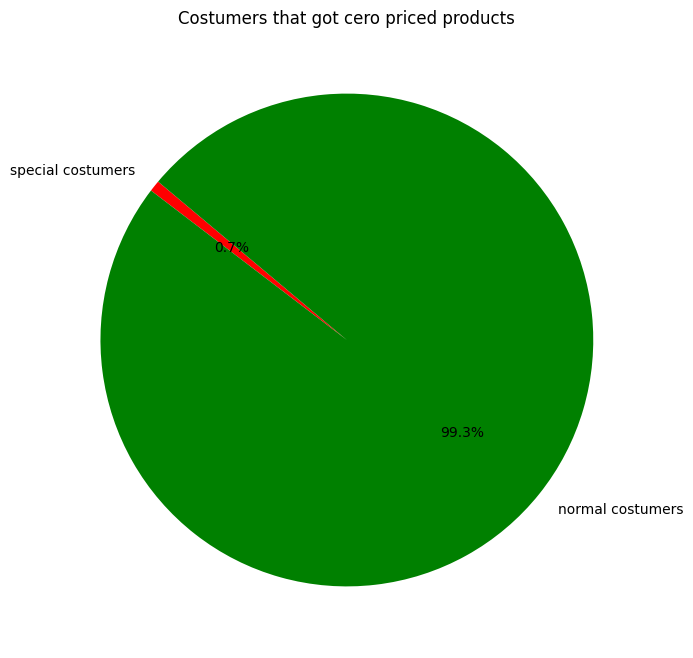

In [49]:

import matplotlib.pyplot as plt

sizes = [cero_customers, normal_customers]
labels = ['special costumers','normal costumers']

# Crear un gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',colors=['red','green'], startangle=140)

# Añadir título
plt.title('Costumers that got cero priced products')

# Mostrar el gráfico
plt.show()

Del total número de clientes solo el `0.7%` realizó transacciones de productos con precios igual a cero y del número total de registros solo el `0.2%` tienen productos con precio cero. Los productos comprados por precio cero no es un tipo de transacción que los clientes comunes realicen ni que se repite mucho, concluimos con que es irrelevante para estudiar los patrones de compra de clientes y lo eliminamos.

In [50]:
df = df.drop(df[df['UnitPrice'] == 0].index)

####**StockCodes**

Al ser una tienda online, se espera que en las transacciones haya una parte dedicada al envío de los productos adquiridos.

Encontramos que el StockCode `'POS'` hace referencia según la descripción, al servicio de envío postal. Este servicio no lo consideramos como producto de la tienda ya que no aporta ninguna información sobre las preferencias de los clientes.

In [51]:
df[df['StockCode'] == 'POST']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.0,12583,France
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.0,12791,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.0,12662,Germany
5073,536840,POST,POSTAGE,1,2010-12-02 18:27:00,18.0,12738,Germany
5258,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.0,12686,France
...,...,...,...,...,...,...,...,...
541198,581493,POST,POSTAGE,1,2011-12-09 10:10:00,15.0,12423,Belgium
541216,581494,POST,POSTAGE,2,2011-12-09 10:13:00,18.0,12518,Germany
541730,581570,POST,POSTAGE,1,2011-12-09 11:59:00,18.0,12662,Germany
541767,581574,POST,POSTAGE,2,2011-12-09 12:09:00,18.0,12526,Germany


In [52]:
df = df.drop(df[df['StockCode'] == 'POST'].index)
if df[df['StockCode'] == 'POST'].shape[0] == 0:
  print('Se ha eliminado correctamente')

Se ha eliminado correctamente


Nos damos cuenta de que por lo general, el atributo `StockCode` es un código con números y a veces letras. No obstante, hay algunos registros con `StockCode` que no tienen forma de código, vamos a analizar esos casos.

Veamos los `StockCode` que tienen longitud 1.

In [53]:
# Convertir los valores de la columna 'StockCode' a cadenas de texto
codigos = df['StockCode'].unique()
codigos = codigos.astype(str)
v = []
for registro in codigos:
  if len(registro) < 2:
    v.append(registro)
# Convertir el vector en un conjunto para eliminar los duplicados
conjunto = set(v)

# Convertir el conjunto de nuevo en una lista
v= list(conjunto)
print(v)

['S', 'M', 'B', 'm']


También eliminamos un error de transcripcion

In [54]:
df.loc[df['StockCode'] == 'm', 'StockCode'] = 'M'

Para analizarlos en base a sus descripciones:

In [55]:
# DataFrame vacío para almacenar los resultados
df_concatenado = pd.DataFrame()
for element in v:
  df_concatenado = pd.concat([df[df['StockCode'] == element], df_concatenado])
# Agrupamos por descripcion
df_concatenado.groupby('StockCode')['Description'].unique()

StockCode
B    [Adjust bad debt]
M             [Manual]
S            [SAMPLES]
Name: Description, dtype: object

In [56]:
df_concatenado[df_concatenado['StockCode'] == 'S'].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
152709,549684,S,SAMPLES,1,2011-04-11 13:24:00,30.00,15287,United Kingdom
419666,572849,S,SAMPLES,1,2011-10-26 12:20:00,33.05,15287,United Kingdom


In [57]:
df_concatenado[df_concatenado['StockCode'] == 'M'].head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom
5684,536865,M,Manual,1,2010-12-03 11:28:00,2.55,15287,United Kingdom


El `StockCode` con valor 'B' es un ajuste por lo que lo eliminamos, los demás son productos lícitos que tienen precios y cantidades normales.

In [58]:
df = df.drop(df[df['StockCode'] == 'B'].index)



---



Veamos tras la limpieza cómo han cambiado los NaN.
- Con el dataset original:

In [59]:
ds.isna().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

- Con el dataset limpiado:

In [60]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Tras la limpieza de la base de datos, no aparece ningún valor NaN.

###**Preparación para el algoritmo GSP**

Creamos una copia del dataset limpio.

In [61]:
ds = df.copy()
id(df), id(ds)

(132927060559088, 132926869303504)

Ordenamos el DataFrame por *CostumerID* e *InvoiceDate* para asegurar que las transacciones estén en orden cronológico para cada cliente

In [62]:
df.sort_values(by=['CustomerID', 'InvoiceDate'], inplace=True)
df.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
14938,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347,Iceland
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347,Iceland
14940,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347,Iceland


###**Aplicación del algoritmo GSP**

Instalamos la librería GSP de python.

In [64]:
!pip install gsppy

In [65]:
from gsppy.gsp import GSP

Hemos probado mediante varias agrupaciones: por cliente y por descripción, por factura y stockcode, ... pero el algoritmo no obtenía ninguna secuencia relevante (con más de 2 items).

In [68]:
ds.groupby('InvoiceNo')['Description'].unique()

InvoiceNo
536365    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
536366    [HAND WARMER UNION JACK, HAND WARMER RED POLKA...
536367    [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
536368    [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
536369                           [BATH BUILDING BLOCK WORD]
                                ...                        
581583    [LUNCH BAG RED RETROSPOT, 6 CHOCOLATE LOVE HEA...
581584    [RED FLOCK LOVE HEART PHOTO FRAME, 6 CHOCOLATE...
581585    [BLACK TEA TOWEL CLASSIC DESIGN, ASSORTED BOTT...
581586    [LARGE CAKE STAND  HANGING STRAWBERY, SET OF 3...
581587    [CIRCUS PARADE LUNCH BOX , PLASTERS IN TIN CIR...
Name: Description, Length: 19883, dtype: object

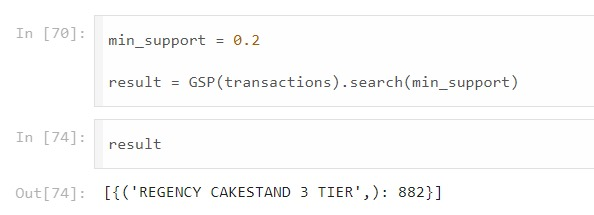

Es por ello que le daremos otro enfoque al problema.

Como no se ha obtenido ninguna secuencia relevante, probamos a depurar más los datos y repetir el algoritmo.

## Simplificación de los datos

Al tratarse de una base de datos tan grande, es computacionalmente costoso operar el algoritmo GSP, es por ello que vamos a agrupar las transacciones realizadas por un mismo cliente en un periodo menor a 1h. Para ello, eliminaremos los minutos del atributo `InvoiceDate` y unificaremos todas las compras en una hora como la misma transacción.

De esta manera, el número de listas input a la función `gsp` será mucho menor.

In [69]:
ds['InvoiceDate'].nunique()

18428

Hay `18429` fechas distintas, se ha de tener en cuenta que al contar los segundos, es muy fácil que las compras se realicen en muchas fechas distintas, aunque sea por diferencia de segundos.

In [70]:
ds.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom


Interpretamos que compras realizadas en la misma hora pertenecen a la misma transacción.

In [71]:
# Eliminar los minutos de la columna 'InvoiceDate'
ds['InvoiceDate'] = ds['InvoiceDate'].astype(str).str.slice(stop=-6)
ds.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08,2.75,17850,United Kingdom


In [72]:
ds['InvoiceDate'].nunique()

2900

Pasamos a  `2900` fechas distintas.

Tomamos como ejemplo el primer cliente, agrupamos sus compras por fecha.

In [77]:
ds_cliente1 = ds[ds['CustomerID'] == 17850]
x = ds_cliente1.groupby('InvoiceDate')['Description'].unique()
x

InvoiceDate
2010-12-01 08    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
2010-12-01 09    [HAND WARMER RED POLKA DOT, HAND WARMER UNION ...
2010-12-01 10    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
2010-12-01 11    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
2010-12-02 08    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
2010-12-02 09    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
2010-12-02 10    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
2010-12-02 12    [RED WOOLLY HOTTIE WHITE HEART., SET 7 BABUSHK...
2010-12-02 14    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
2010-12-02 15    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
Name: Description, dtype: object

A primera vista se observan algunas secuencias que se repiten.

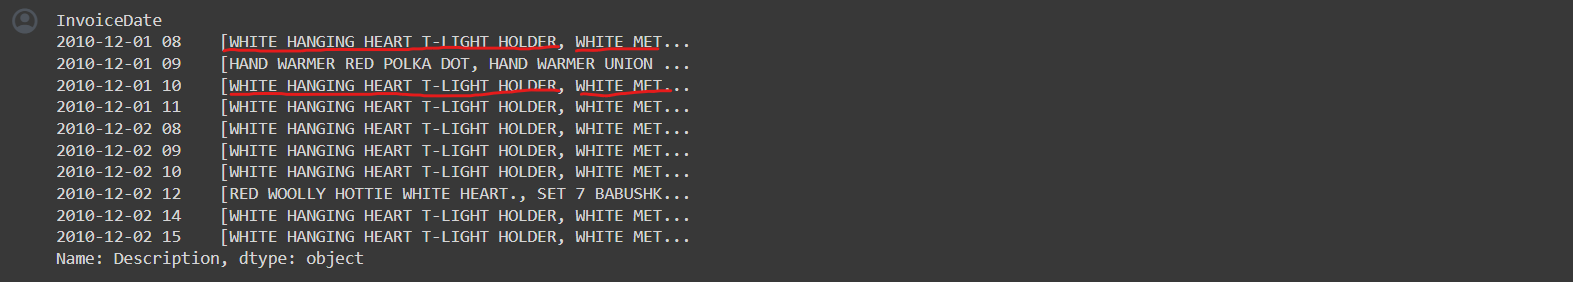

Lo transformamos a una lista para poder aplicar el algoritmo.

In [78]:
x = x.apply(list).tolist()

Y ejecutamos GSP usando solo las 3 primeras transacciones y con una frecuencia de soporte 0.9 alta para mayor velocidad de cómputo.

In [79]:
result = GSP(x[:3]).search(0.9)
result

[{('WHITE HANGING HEART T-LIGHT HOLDER',): 3,
  ('WHITE METAL LANTERN',): 3,
  ('KNITTED UNION FLAG HOT WATER BOTTLE',): 3,
  ('CREAM CUPID HEARTS COAT HANGER',): 3,
  ('RED WOOLLY HOTTIE WHITE HEART.',): 3,
  ('SET 7 BABUSHKA NESTING BOXES',): 3,
  ('GLASS STAR FROSTED T-LIGHT HOLDER',): 3,
  ('HAND WARMER UNION JACK',): 3,
  ('HAND WARMER RED POLKA DOT',): 3},
 {('KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.'): 3,
  ('RED WOOLLY HOTTIE WHITE HEART.', 'SET 7 BABUSHKA NESTING BOXES'): 3,
  ('WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN'): 3,
  ('WHITE METAL LANTERN', 'CREAM CUPID HEARTS COAT HANGER'): 3},
 {('KNITTED UNION FLAG HOT WATER BOTTLE',
   'RED WOOLLY HOTTIE WHITE HEART.',
   'SET 7 BABUSHKA NESTING BOXES'): 3,
  ('WHITE HANGING HEART T-LIGHT HOLDER',
   'WHITE METAL LANTERN',
   'CREAM CUPID HEARTS COAT HANGER'): 3}]

El codigo a seguir para el resto de clientes, sería el siguiente, y luego se podría hacer GSP con los resultados de todos los clientes. No obstante es demasiado costoso computacionalmente, habría que depurar más la base de datos o hacerlo con un ordenador potente.

In [80]:
#for client in df['CustomerID'].unique():
#  ds_client = df[df['CustomerID'] == client]
# ds_client_grouped = ds_client.groupby('InvoiceDate')['Description'].unique().apply(list).tolist()
#  result = GSP(ds_client_grouped).search(0.8)
#  print(result)



## Conclusiones con las secuencias obtenidas:

Analizamos las secuencias con más de un producto más relevantes. Nota: el hecho de que las secuencias proporcionadas estén etiquetadas con "3" indica que estas secuencias específicas ocurrieron tres veces en los datos. Teniendo en cuenta que ejecutamos el algoritmo con muy pocas muestras de compras, es un número aceptable de frecuencia.



**Sequencia 1.**
`('KNITTED UNION FLAG HOT WATER BOTTLE', 'RED WOOLLY HOTTIE WHITE HEART.')
`
. Podríamos crear un paquete llamado "Noche de Invierno Acogedora", que incluya el "KNITTED UNION FLAG HOT WATER BOTTLE", el "RED WOOLLY HOTTIE WHITE HEART." y el "SET 7 BABUSHKA NESTING BOXES". Aprovechando así también la **Secuencia 2.** `('RED WOOLLY HOTTIE WHITE HEART.', 'SET 7 BABUSHKA NESTING BOXES')`.

**Secuencia 3** `('WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN')`
ofrece descuentos o promociones especiales para aquellos que compren los productos en las secuencias sugeridas juntos. Por ejemplo, "Compra el WHITE HANGING HEART T-LIGHT HOLDER y el WHITE METAL LANTERN juntos y ahorra un 10% en tu próxima compra". Además con 'CREAM CUPID HEARTS COAT HANGER' se podría añadir a la oferta el envío gratis. **Secuencia 4** `('WHITE HANGING HEART T-LIGHT HOLDER','WHITE METAL LANTERN','CREAM CUPID HEARTS COAT HANGER')`

Al aplicar estas estrategias, puedes se aprovechan las tendencias de compra observadas en las secuencias para aumentar las ventas y mejorar la experiencia del cliente.